In [153]:
# math related packages
import scipy as sc
import qutip as qt
# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0) 
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)



def sigmoid(s,t,u):
    return 1/(1+np.exp(-(s/t)**u))*((np.pi)/2)
def ver_sigmoid(x,y,gamma):
    return x*(-np.log((np.pi/(2*(np.arccos(y**(1/2)))))-1))**(1/gamma)
'''
def sigmoid(x):
    return ((np.pi)/2)/(1+np.exp(-x))
def ver_sigmoid(y):
    return -np.log((np.pi/(2*(np.arccos(y**(1/2)))))-1)
'''



def qb_2xtrans(a,b,c,d):# transform normal data to qubit(Bloch sphere representation)
    r= qt.tensor(np.cos(np.pi*a)*qubit0+np.exp(2*np.pi*1j*b)*np.sin(a*np.pi)*qubit1, np.cos(np.pi*c)*qubit0+np.exp(2*np.pi*1j*d)*np.sin(c*np.pi)*qubit1)
    return r


def qb_ytrans(a):# transform normal data to qubit(Bloch sphere representation)

    r=np.cos(a)*qubit0+np.sin(a)*qubit1
    return r


def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = np.random.normal(size=(dim,dim)) + 1j * np.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = np.random.normal(size=(dim,1)) + 1j * np.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t = randomQubitState(numQubits)
        ut = unitary*t
        trainingData.append([t,ut])
    #Return
    return trainingData

In [154]:
#def randomNetwork(qnnArch, numTrainingPairs):
def randomNetwork(qnnArch):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."
    
    #Create the targeted network unitary and corresponding training data
    '''
    networkUnitary = randomQubitUnitary(qnnArch[-1])
    print(networkUnitary)
    networkTrainingData = randomTrainingData(networkUnitary, numTrainingPairs)
    print(networkTrainingData)
    '''
    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        #print(l)
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]
        #print(numInputQubits)
        #print(numOutputQubits)
        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0: 
                #print(j,"0:",randomQubitUnitary(numInputQubits+1))
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                #print(j,"1:",unitary)
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
                #print(j,"2:",unitary)
            networkUnitaries[l].append(unitary)
    #print(networkUnitaries)
    #Return
    #return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)
    return (qnnArch, networkUnitaries)

In [155]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
        #print(trainingData[i][1][0])
        #print(trainingData[i][1][0]**2)
        #print(outputStates[i][0,0])
    return costSum.tr()/len(trainingData)
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni
    
    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]
    
    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)
        
        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)
        
        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))
    
    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni
    
    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)
    
    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni
        
    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):
    
    ### FEEDFORWARD    
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]
    
    #Optional
    runtime = time()
    
    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))
        
        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)
        
        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]
            
            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])
        
        ### FEEDFORWARD
        
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
        
        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
            #print(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
        #plotlist[1].append(np.log10(1-costFunction(trainingData, outputStates)))
    
    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")
    print(costFunction(trainingData, outputStates))
    
    #Return
    return [plotlist, currentUnitaries, outputStates]

In [156]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

In [157]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 200,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2




xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))

maturity time  range:
0.5005061583846219 0.5990505142000673
Stock price  range:
0.9804335060592119 1.0199887069314453
interest rate  range:
0.030905509191042024 0.07949801161949727
option value  range:
0.08888444152061992 0.23235287647915875
sigma range:
0.30220884684944094 0.6947547746402069
(200, 4)
maturity time  range:
0.5005061583846219 0.5990505142000673
Stock price  range:
0.9804335060592119 1.0199887069314453
interest rate  range:
0.030905509191042024 0.07949801161949727
time option-value  range:
-2.7492594136365516 -1.6546771696911975
sigma range:
0.30220884684944094 0.6942601816442402
(160, 4)


In [158]:
print(xtv_train_log)

[[ 0.57957927  1.00092391  0.07327536 -2.49032338]
 [ 0.5428994   0.98689279  0.05825666 -1.72228013]
 [ 0.56454723  1.00824969  0.04346216 -1.87395206]
 [ 0.52652024  0.98230235  0.06091274 -2.05027975]
 [ 0.56601974  1.01879658  0.03332481 -2.20912397]
 [ 0.59307573  0.99895847  0.0736062  -2.19199462]
 [ 0.56311386  0.98468268  0.04262185 -2.41743029]
 [ 0.58492234  1.01009498  0.06741298 -2.28432449]
 [ 0.54338516  1.00686803  0.05513602 -2.25963743]
 [ 0.5465598   0.98181786  0.05858063 -1.81838469]
 [ 0.58359801  0.98180875  0.04744341 -1.83840367]
 [ 0.56830068  1.00488347  0.04986436 -2.30242348]
 [ 0.50091971  1.01582093  0.05303894 -2.50272161]
 [ 0.55543541  0.99659278  0.03698862 -1.74720267]
 [ 0.51732943  1.01242213  0.07825135 -2.50498986]
 [ 0.59132406  1.01564572  0.05622557 -1.79931911]
 [ 0.54916159  1.01816204  0.05313399 -1.73345518]
 [ 0.56228905  1.01897579  0.03771814 -2.60554189]
 [ 0.5094443   0.99586171  0.03637443 -2.00716659]
 [ 0.57699936  1.00334624  0.04

In [159]:
trainingData=[]
for i in range(len(xtv_train_log)):
    '''
    u=qt.tensor(qb_ytrans(xtv_train_log[i][0]),qb_ytrans(xtv_train_log[i][1]))
    u=qt.tensor(u,qb_ytrans(xtv_train_log[i][2]))
    u=qt.tensor(u,qb_ytrans(xtv_train_log[i][3]))
    
    #ut=qb_trans(sigmoid(y_train[i],x_train[i],0.8))
    ut=qt.tensor(qb_ytrans(ytv_train_log[i]), qubit0)
    ut=qt.tensor(ut, qubit0)
    ut=qt.tensor(ut, qubit0)
    '''
    u=qb_2xtrans(xtv_train_log[i][0], xtv_train_log[i][1], xtv_train_log[i][2], xtv_train_log[i][3])
    ut=qt.tensor(qb_ytrans(ytv_train_log[i]), qubit0)
    #print(ut[0]**2)
    #print(ut[0,0])
    trainingData.append([u,ut])
print(trainingData)


[[Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.24088288+0.j        ]
 [ 0.05634797+0.00343018j]
 [ 0.94333572+0.00547624j]
 [-0.22058966-0.01471416j]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.94061884]
 [0.        ]
 [0.33946459]
 [0.        ]]], [Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.13212077+0.j        ]
 [ 0.00423767-0.02408425j]
 [ 0.97107972-0.08015456j]
 [-0.01653526+0.17958868j]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.7907004 ]
 [0.        ]
 [0.61220329]
 [0.        ]]], [Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[-0.19951981+0.j        ]
 [-0.01925593-0.01951119j]
 [ 0.96909047+0.05027719j]
 [ 0.08861159+0.09962039j]], Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[0.83990226]
 [0.        ]
 [0.54273768]
 [0.        ]]], [Quantum 

In training round 0
In training round 100
In training round 200
In training round 300
In training round 400
In training round 500
In training round 600
In training round 700
In training round 800
In training round 900
Trained 1000 rounds for a [2, 3, 4, 3, 2] network and 160 training pairs in 18359.67 seconds
0.9901575386141099
Exceeds cost of 0.99 at training step 918


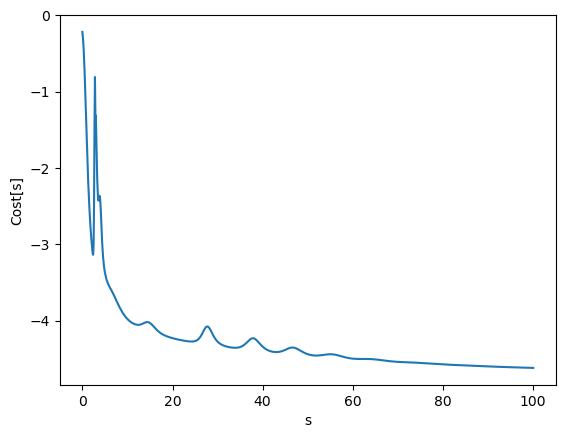

In [160]:
network23432 = randomNetwork([2,3,4,3,2])
trained23432_result=qnnTraining(network23432[0], network23432[1], trainingData, 1, 0.1, 1000, 100)
plotlist23432 = trained23432_result[0]

for i in range(len(plotlist23432[1])):
    if plotlist23432[1][i] >= 0.99:
        print("Exceeds cost of 0.99 at training step "+str(i))
        break

plt.plot(plotlist23432[0], np.log([1-element for element in plotlist23432[1]]))
plt.xlabel("s")


plt.ylabel("Cost[s]")
plt.show()

In [161]:
train_out=trained23432_result[2]
train_out_y_list=[]
print(train_out)

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 8.02920643e-01+0.00000000e+00j  1.26143873e-03-7.74520525e-04j
   3.90305453e-01-6.77470169e-02j  5.32226337e-04-8.35240679e-04j]
 [ 1.26143873e-03+7.74520525e-04j  1.53317625e-04+0.00000000e+00j
   7.00793582e-04+2.89625038e-04j -1.52460494e-06-4.76569329e-05j]
 [ 3.90305453e-01+6.77470169e-02j  7.00793582e-04-2.89625038e-04j
   1.96802890e-01+0.00000000e+00j  3.16495964e-04-3.69097916e-04j]
 [ 5.32226337e-04+8.35240679e-04j -1.52460494e-06+4.76569329e-05j
   3.16495964e-04+3.69097916e-04j  1.23149430e-04+0.00000000e+00j]], Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[7.22410383e-01+0.00000000e+00j 8.92298806e-04-5.10777046e-05j
  4.44511753e-01-4.88432272e-02j 5.26047742e-04-5.55858058e-04j]
 [8.92298806e-04+5.10777046e-05j 7.06823466e-05+0.00000000e+00j
  5.98855878e-04-5.42119548e-06j 5.35420661e-06-2.12694066e-05j]
 [4.44511753e-0

In [162]:
for i in range(len(ytv_train_log)):
    
    train_out_y=train_out[i][0,0]

    train_out_y_list.append(float(train_out_y))

y_train=np.cos(ytv_train_log)**2

print(y_train)
print(train_out_y_list)

train_MSE=metrics.mean_squared_error(y_train,train_out_y_list)
train_RMSE=train_MSE**(1/2)

train_MAE=metrics.mean_absolute_error(y_train,train_out_y_list)
train_MAPE=metrics.mean_absolute_percentage_error(y_train,train_out_y_list)
train_R2=metrics.r2_score(y_train, train_out_y_list)
print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

[0.8847638  0.62520713 0.70543581 0.78476763 0.82833452 0.81881919
 0.90189418 0.83633564 0.83346972 0.68875756 0.72379716 0.85503574
 0.87431747 0.65556628 0.86609789 0.6565366  0.59974552 0.90684179
 0.76606819 0.76245529 0.73887072 0.7940726  0.87043912 0.65007133
 0.65921767 0.7567774  0.90474575 0.85068386 0.88381051 0.76379616
 0.67177298 0.63924035 0.72375211 0.77177253 0.62696879 0.65932269
 0.86250789 0.59608391 0.90543962 0.8729281  0.68787279 0.8952303
 0.83022859 0.75131386 0.62516627 0.82616316 0.7241898  0.8323549
 0.8905152  0.8421769  0.83606458 0.84784158 0.72272105 0.60505521
 0.59681874 0.82194533 0.68927224 0.89910851 0.76534259 0.65958057
 0.87431107 0.89742339 0.77107662 0.90415818 0.89451005 0.83822213
 0.90796291 0.65148439 0.61254636 0.73228318 0.82749609 0.81094906
 0.62908485 0.77369157 0.67285743 0.88624558 0.83937117 0.84582543
 0.75800082 0.73833584 0.88318323 0.85438666 0.85062598 0.7098378
 0.66799473 0.81350414 0.84606755 0.76924881 0.72740454 0.7899778

C:\Users\73\AppData\Local\Temp\ipykernel_16552\3027370134.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  train_out_y_list.append(float(train_out_y))


<function matplotlib.pyplot.show(close=None, block=None)>

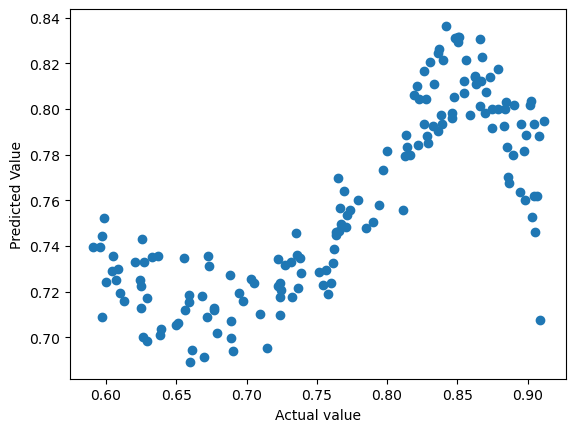

In [163]:
plt.scatter(y_train,train_out_y_list)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show

In [165]:
#################test####################
testData=[]
for i in range(len(xtv_test_log)):

    u_test=qb_2xtrans(xtv_test_log[i][0], xtv_test_log[i][1], xtv_test_log[i][2], xtv_test_log[i][3])
    #print(u)
    ut_test=qt.tensor(qb_ytrans(ytv_test_log[i]), qubit0)
    testData.append([u_test,ut_test])
    
    
    


learnedUnitaries = trained23432_result[1]

storedStates = feedforward([2,3,4,3,2], learnedUnitaries, testData)
outputStates = []
for k in range(len(storedStates)):
    t_qstate=storedStates[k][-1]

    t_out=t_qstate[0,0]

    outputStates.append(float(t_out))

    
y_test=np.cos(ytv_test_log)**2
print(y_test)
print(outputStates)
test_MSE=metrics.mean_squared_error(y_test,outputStates)
test_RMSE=train_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(y_test,outputStates)
test_MAPE=metrics.mean_absolute_percentage_error(y_test,outputStates)

test_R2=metrics.r2_score(y_test, outputStates)
print("test_MSE:",test_MSE)
print("test_RMSE:",test_RMSE)
print("test_MAE:",test_MAE)
print("test_MAPE:",test_MAPE)
print("test_R2:",test_R2)


[0.77223615 0.86695913 0.73299821 0.85188357 0.91109125 0.63511305
 0.59014771 0.70786479 0.71957758 0.71332184 0.87828671 0.6144957
 0.64897974 0.81595834 0.65586754 0.8071143  0.89166418 0.87724622
 0.8244272  0.89510629 0.85463009 0.83246591 0.90069436 0.74920968
 0.75562536 0.80650095 0.83044741 0.66156674 0.79421273 0.88374099
 0.69670524 0.79264607 0.6155932  0.68897942 0.62088212 0.62115357
 0.82676315 0.69856207 0.89121689 0.67322311]
[0.7438254050307951, 0.8232989186736137, 0.7060205242676076, 0.832409728593966, 0.7933592409660375, 0.7027020144618009, 0.7341014671942443, 0.7321784552080004, 0.7333951282715653, 0.7129222705620718, 0.8064887453246669, 0.740312268670052, 0.709130492659759, 0.8322609396978462, 0.7115249350991012, 0.817167576047418, 0.8076807673397418, 0.8143977055109208, 0.780704237216643, 0.8000602675905911, 0.8204277855387077, 0.7772712672883246, 0.7506442207141565, 0.7301603683149709, 0.7341985612535079, 0.7566891316274731, 0.8308552593500148, 0.730175252669911

C:\Users\73\AppData\Local\Temp\ipykernel_16552\2146026803.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  outputStates.append(float(t_out))


In [167]:
X1,Y1=bsm_iv_generator(num_sample = 5000,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.98,1.02], rr_bound=[0.03,0.08],callput='call')
X1,Y1=logscale_vol(X1,Y1,otm_lower=1e-4)

test1Data=[]
for i in range(len(X1)):

    u1_test=qb_2xtrans(X1[i][0], X1[i][1], X1[i][2], X1[i][3])

    ut1_test=qt.tensor(qb_ytrans(Y1[i]), qubit0)
    test1Data.append([u1_test,ut1_test])


storedStates1 = feedforward([2,3,4,3,2], learnedUnitaries, test1Data)
outputStates1 = []
for k in range(len(storedStates1)):
    t1_qstate=storedStates1[k][-1]
    t1_out=t1_qstate[0,0]
    outputStates1.append(float(t1_out))

    
y_test1=np.cos(Y1)**2
print(y_test1)
print(outputStates1)
test1_R2 = metrics.r2_score(y_test1, outputStates1)
test1_MSE=metrics.mean_squared_error(y_test1,outputStates1)
test1_RMSE=test1_MSE**(1/2)
test1_MAE=metrics.mean_absolute_error(y_test1,outputStates1)
test1_MAPE=metrics.mean_absolute_percentage_error(y_test1,outputStates1)

print("train_MSE:",test1_MSE)
print("train_RMSE:",test1_RMSE)
print("train_MAE:",test1_MAE)
print("train_MAPE:",test1_MAPE)
print("train_R2:",test1_R2)





[0.81094906 0.60433992 0.68787279 ... 0.82535612 0.65642872 0.73661178]
[0.7813682069097423, 0.717689246823709, 0.7087042281032563, 0.7376202240302111, 0.8034015197086037, 0.7950679570592478, 0.8056514579963324, 0.7157976905346651, 0.7368184478944747, 0.7267788289433387, 0.7601439716244005, 0.7472634493794311, 0.6882745083779869, 0.8137574857955521, 0.8197462934477217, 0.8312619419447139, 0.792078234446051, 0.7356550195080558, 0.7455601528720176, 0.8051510553835406, 0.7228011207468039, 0.8289806305396131, 0.7887446216849574, 0.7729829977875856, 0.7530084689106006, 0.6923354844474703, 0.8054370457030968, 0.7744565596746348, 0.7258880923057558, 0.7664365172761038, 0.710718998539386, 0.7905527787234886, 0.7806769958508086, 0.6977724839190799, 0.7167804146830308, 0.6961631436006118, 0.8069023030587248, 0.8120739603675026, 0.7005079803937839, 0.7387978918224226, 0.7921367156253553, 0.7403519121555481, 0.7905812409015293, 0.7157600023554735, 0.8271954949416643, 0.713451221101439, 0.775006130

C:\Users\73\AppData\Local\Temp\ipykernel_16552\1171148157.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  outputStates1.append(float(t1_out))
